## Testing Grounds for DAWN 2/16 - 3/7 : CDO Tool

Zack Sating
    

### Notes:  
Illinois has lat 36.98 to 42.49 (S to N) and long -87.52 to -91.51 (E to W)

The CDO (Climate Data Operators) is a command line tool that does lots of powerful operations on netCDF (.nc) and GRIB data, like modification, selection, filtering, arithmetic, statistics, interpolation, I/O, plotting, and more. 

Download CDO tool [here](https://code.mpimet.mpg.de/projects/cdo/wiki/Cdo#Documentation) (I just ran 'brew install cdo' on mac and it worked, can also do conda I guess if you work in docker)  

Some useful commands:
- `cdo -griddes <filename>` : gets dimensions of grid, increments of grid in degrees in my case
- `ncdump -h <filename>` : variables you have and their dimensions
- `cdo sellonlatbox,lon1,lon2,lat1,lat2  infile outfile` : selects a rectangle of some data using coordinate bounds, I use this for getting outfile to only have the data for a select state, reduced the file size of about 98%.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
import subprocess

STATE = "IL"
INPUT_PATH, OUTPUT_PATH = ".", "."
IN_DAWN_SERVER = False
if IN_DAWN_SERVER:
  INPUT_PATH = "/mnt/gfs01/DAWN-ML/et_data_nc"

Original ET (evapotranspiration) dataset covering the whole US from latitude: (24, 49) and longitude: (-125, -66) 

In [2]:
ds = xr.open_dataset(f"{INPUT_PATH}/2020365.nc")
df = ds.to_dataframe()
df

ET
lat       lon                     
49.799999 -125.040001 -4079.592041
          -125.000000 -4079.592041
          -124.959999 -4079.592041
          -124.919998 -4079.592041
          -124.879997 -4079.592041
...                            ...
24.840000 -67.000000  -4079.592041
          -66.959999  -4079.592041
          -66.919998  -4079.592041
          -66.879997  -4079.592041
          -66.839996  -4079.592041

[910000 rows x 1 columns]

Now we'll use CDO to select only the points in IL (Illinois) using the `sellatlonbox` command:
  
`% cdo sellonlatbox,-91.51,-87.52,36.98,42.49 2020365.nc test.nc`

In [3]:
arg0 = "cdo"
arg1 = "sellonlatbox,-91.51,-87.52,36.98,42.49"

output = subprocess.run([arg0, arg1, f"{INPUT_PATH}/2020365.nc", "test.nc"], shell=False, capture_output=True)

ds = xr.open_dataset(f"test.nc")
df = ds.to_dataframe()
df

ET
lon        lat                
-91.480003 42.480000  0.343101
           42.439999  0.354377
           42.400002  0.350219
           42.360001  0.391174
           42.320000  0.357293
...                        ...
-87.559998 37.160000  0.027705
           37.119999  0.027841
           37.080002  0.022549
           37.040001  0.022175
           37.000000  0.024928

[13662 rows x 1 columns]

In [4]:
# from netCDF4 import Dataset
data = Dataset("test.nc", "r", format="NETCDF4")

LAT = data.variables['lat'][:]  
LON = data.variables['lon'][:]
data = data.variables['ET'][:]

## Slight pre-processing
Just gotta set all of the lakes and bodies and water to NaN since those are negative

In [5]:
print(data.shape, LAT.shape, LON.shape)
data[data<0] = np.nan

(138, 99) (138,) (99,)


Now we see our lat and lon bounds are clearly met and our file size has reduced dramatically from the original:

In [6]:
us_size = os.path.getsize(f'{INPUT_PATH}/2020365.nc')
il_size = os.path.getsize('test.nc')
print(f"size of US file : {us_size//1000} KB")
print(f"size of IL file : {il_size//1000} KB")
print(f"reduction in size: {round((1-(il_size/us_size)) *100, 2)}%")

size of US file : 3655 KB
size of IL file : 70 KB
reduction in size: 98.07%


The folder size of all 20 years of ET data is about 25GB, so getting a 98% reduction should give us a new size of 0.5GB

## Plotting

Let's plot it to make sure everything is still intact

<ipython-input-7-b8cfc3f6b403>:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')


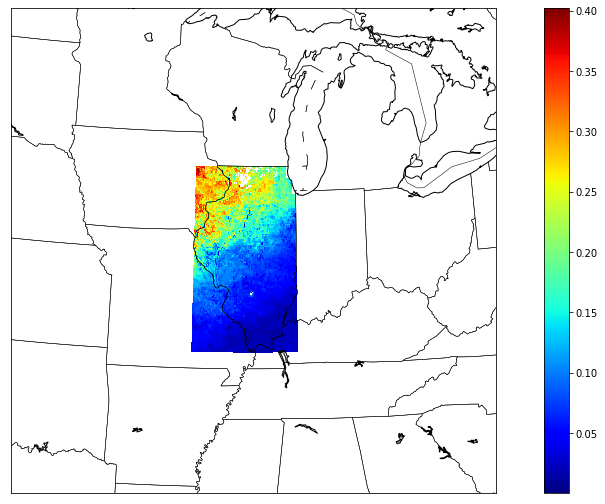

In [7]:
plt.figure(figsize=(10,10))

universal_map = Basemap(projection='lcc', resolution='i',
            width= 1.6E6, height= 1.6E6, 
            lat_0= 40, lon_0= -89.2)

# Basemap wants it's own type of x & y aside from the meshgrid, so just follow this
lons, lats = np.meshgrid(LON, LAT)
x,y = universal_map(lons, lats) #mapping them together 

# consider this as the outline for the map that is to be created 
universal_map.drawcoastlines()
universal_map.drawstates()
universal_map.drawcountries()

c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')
cbar1 = universal_map.colorbar(c_scheme1, location='right', pad='10%') # map information
plt.show()

## Now let's make a script to do this for all of our files

the data of particular interest for this notebook is the evapotranspiration data in `/mnt/gfs01/DAWN-ML/et_data_nc/` where's there's daily `.nc` files for every year from [2001, 2020], so we'll write a script for that, and a test script before that to ensure it'll work

In [8]:
from subprocess import run
from os import listdir
from re import match
from time import strftime

arg0 = "cdo"
arg1 = "sellonlatbox,-91.51,-87.52,36.98,42.49"

filenames = listdir(INPUT_PATH)
count = 0

for filename in filenames:

  # ensure we're running cdo on the correct .nc file
  if not match("^\d{7}\.nc$", filename):
    continue
  
  # good file, so run cdo on it
  cmd_output = run([arg0, arg1, f"{INPUT_PATH}/{filename}", f"{OUTPUT_PATH}/IL_data/{STATE}_{filename}"], shell=False, capture_output=True)

  # ensure that it ran successfully
  if cmd_output.returncode != 0:
    print(f"error with cdo:\n{cmd_output}")
  else:
    count += 1
  
  # print output to give feedback that the program is running
  if count % 365 == 0:
    print(f"{strftime('%X')} : processed {count//365} year(s) of data")
  
print(f"done. processed {count} files in total")

done. processed 3 files in total


## Validation

Plot these output to make sure they look good

<ipython-input-9-995ea70ca1a3>:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')


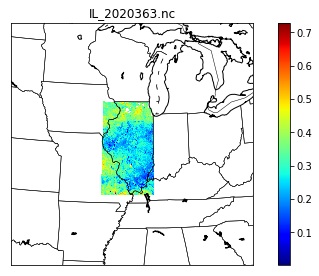

<ipython-input-9-995ea70ca1a3>:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')


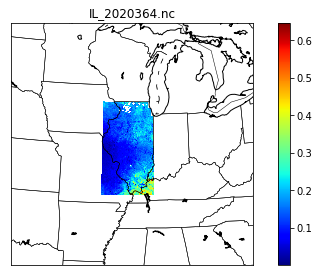

<ipython-input-9-995ea70ca1a3>:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')


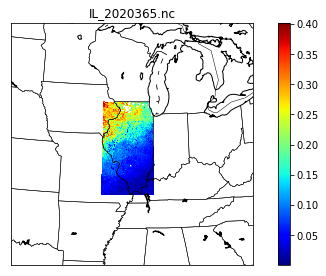

In [9]:
lons, lats = np.meshgrid(LON, LAT)
x,y = universal_map(lons, lats) #mapping them together

filenames = sorted([f for f in listdir(f"{INPUT_PATH}/IL_data/") if match("^IL_\d{7}\.nc$", f)])
for filename in filenames:

  plt.figure(figsize=(5,5))

  universal_map = Basemap(projection='lcc', resolution='i',
              width= 1.6E6, height= 1.6E6, 
              lat_0= 40, lon_0= -89.2)

  data = Dataset(F"{INPUT_PATH}/IL_data/{filename}", "r", format="NETCDF4")

  LAT = data.variables['lat'][:]  
  LON = data.variables['lon'][:]
  data = data.variables['ET'][:]
  data[data<0] = np.nan

  # consider this as the outline for the map that is to be created 
  universal_map.drawcoastlines()
  universal_map.drawstates()
  universal_map.drawcountries()

  c_scheme1 = universal_map.pcolormesh(x, y, data, cmap='jet')
  cbar1 = universal_map.colorbar(c_scheme1, location='right', pad='10%') # map information
  plt.title(filename)
  plt.show()

# combining the daily files into one file

to do this, one way is just using xarray's concat() function, but I can't figure out how to properly name them days besides just integers, so we'll have to keep track of which day we're on with some array of all of the day names (when interpolating later)

In [11]:
filenames = sorted([f for f in listdir(f"{INPUT_PATH}/IL_data") if match("^IL_\d{7}\.nc$", f)])

# create files with time step added
# for filename in filenames:
#   ds = xr.open_dataset(f"{INPUT_PATH}/IL_data/{filename}")
#   ds = xr.merge([xr.Dataset({'time':('time', ['2020365'])}), ds])
#   _ = run(["rm", f"{OUTPUT_PATH}/time_data/{filename}"]) ## i remove each one before i write bc xarray wont write over it
#   ds.to_netcdf(path=f"{OUTPUT_PATH}/time_data/{filename}", mode='w')

In [12]:
IL_datasets = [xr.open_dataset(f"{INPUT_PATH}/IL_data/{d}") for d in filenames]
concat = xr.concat(objs=IL_datasets, dim='time')
concat.to_netcdf(path="./combined.nc", mode="w")
concat.to_dataframe()

ET
lon        lat       time          
-91.480003 42.480000 0     0.333660
                     1     0.195125
                     2     0.343101
           42.439999 0     0.343735
                     1     0.200719
...                             ...
-87.559998 37.040001 1     0.283995
                     2     0.022175
           37.000000 0     0.254633
                     1     0.317162
                     2     0.024928

[40986 rows x 1 columns]

looks a bit weird but the data is still the same, let's make sure we can iterate based on the days

In [13]:
concat.ET.shape

(3, 138, 99)

so we see that it's sorted by time and we can just iterate over the .ET attribute, and we see in the example below that this is exactly 2020363.nc which is our first date 

In [14]:
concat.ET[0]

<xarray.DataArray 'ET' (lat: 138, lon: 99)>
array([[ 3.3366048e-01,  3.4671074e-01,  3.4213802e-01, ...,
        -4.0795920e+03, -4.0795920e+03, -4.0795920e+03],
       [ 3.4373528e-01,  3.1540716e-01,  2.9367194e-01, ...,
        -4.0795920e+03, -4.0795920e+03, -4.0795920e+03],
       [ 3.4121197e-01,  3.9629656e-01,  3.8470519e-01, ...,
        -4.0795920e+03, -4.0795920e+03, -4.0795920e+03],
       ...,
       [ 3.9443102e-01,  4.1600776e-01,  4.5512578e-01, ...,
         2.3442492e-01,  2.0022117e-01,  2.3138304e-01],
       [ 4.0920770e-01,  4.0755802e-01,  4.5317361e-01, ...,
         1.9486746e-01,  2.3944618e-01,  2.2754769e-01],
       [ 3.9198765e-01,  3.8958681e-01,  3.5718399e-01, ...,
         2.6637071e-01,  2.0197506e-01,  2.5463340e-01]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -91.48 -91.44 -91.4 -91.36 ... -87.64 -87.6 -87.56
  * lat      (lat) float32 42.48 42.44 42.4 42.36 ... 37.12 37.08 37.04 37.0
Attributes:
    standard_name:  Evapotranspiration
    units:          mm/day

i don't think we can just append based on the time because that would introduce dynamically sized arrays which xarray doesnt support bc its built on numpy, so this seems like the best option sadly, but we can still just iterate based on the time and keep track of which date we're supposed to be on (i.e. i=0 corresponds to '2001001.nc' or something in our filenames

my partner Matthew also found another way with the nc cmd line tool:

In [ ]:
# os.system("ncecat -u time /mnt/gfs01/DAWN-ML/MODIS_LAI_4DAWN_GeoTiff/*.nc lai_all.nc")
# os.system("ncap2 -O -s 'time[time]=array(7296,1,$time)' lai_all.nc lai_all.nc")
# os.system("ncatted -O -a units,time,o,c,\"days since 2001-01-01\" lai_all.nc")
# os.system("ncatted -O -h -a history,global,o,c,'N/A' lai_all.nc")